In [1]:
## Reload the dataset from the previous step where we have create the edge labels
import torch

# Load the saved dataset
dataset_path = "edge_dataset_with_nodes.pt"  # Update with the correct path if needed
edge_dataset_with_nodes = torch.load(dataset_path)

# Print basic details about the dataset
print(f"Dataset Loaded: {len(edge_dataset_with_nodes)} states")
print(f"Example State Data: {edge_dataset_with_nodes[0]}")
print(f"Edge Attributes Shape: {edge_dataset_with_nodes[0].edge_attr.shape}")
print(f"Node Features Shape: {edge_dataset_with_nodes[0].x.shape if hasattr(edge_dataset_with_nodes[0], 'x') else 'None'}")


/var/tmp/pbs.64362.bright04/ipykernel_3419428/3729062974.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  edge_dataset_with_nodes = torch.load(dataset_path)


Dataset Loaded: 21499 states
Example State Data: Data(x=[24, 3], edge_index=[2, 74], edge_attr=[74, 4], y=[74])
Edge Attributes Shape: torch.Size([74, 4])
Node Features Shape: torch.Size([24, 3])


In [2]:
#### Calculate the edge betweeness centrality and add it to the edge features 
import torch_geometric.utils as pyg_utils
import networkx as nx

# Function to calculate additional edge features
def add_extra_edge_features(dataset):
    """
    Adds additional edge features such as edge centrality and other properties to the dataset.
    """
    updated_dataset = []
    
    for state_data in dataset:
        # Convert to NetworkX graph for centrality computation
        edge_index = state_data.edge_index
        G = pyg_utils.to_networkx(state_data, to_undirected=True)
        
        # Calculate edge centrality
        edge_centrality = nx.edge_betweenness_centrality(G, normalized=True)
        
        # Map edge centrality to edge_index
        centrality_features = []
        for (src, dst) in edge_index.t().tolist():
            # Get centrality value; if bidirectional, ensure both directions are accounted
            centrality_value = edge_centrality.get((src, dst), edge_centrality.get((dst, src), 0))
            centrality_features.append(centrality_value)
        
        # Normalize and convert centrality to tensor
        centrality_tensor = torch.tensor(centrality_features, dtype=torch.float).unsqueeze(1)  # Add dimension
        
        # Combine with existing edge_attr
        if state_data.edge_attr is not None:
            new_edge_attr = torch.cat([state_data.edge_attr, centrality_tensor], dim=1)  # Concatenate along features
        else:
            new_edge_attr = centrality_tensor  # Only the new feature if none exist
        
        # Update edge_attr in the state_data
        state_data.edge_attr = new_edge_attr
        updated_dataset.append(state_data)
    
    return updated_dataset

# Add extra edge features
updated_dataset = add_extra_edge_features(edge_dataset_with_nodes)

# Save the updated dataset
torch.save(updated_dataset, "edge_dataset_with_extra_features.pt")
print("Updated dataset saved with additional edge features!")


/mmfs1/home/muhammad.kazim/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Updated dataset saved with additional edge features!


In [3]:
# validation of the dataset (New one)
# Load the updated dataset
updated_dataset = torch.load("edge_dataset_with_extra_features.pt")

# Inspect the first state for validation
example_state = updated_dataset[0]
print(f"Example State - Edge Attributes Shape: {example_state.edge_attr.shape}")
print(f"First Edge Attributes (including new features): {example_state.edge_attr[:5]}")


/var/tmp/pbs.64362.bright04/ipykernel_3419428/3707154051.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  updated_dataset = torch.load("edge_dataset_with_extra_features.p

Example State - Edge Attributes Shape: torch.Size([74, 5])
First Edge Attributes (including new features): tensor([[ 0.1710, -0.1118, -0.2960, -0.6437,  0.0539],
        [ 0.0621,  0.0611,  0.7040, -0.6437,  0.1073],
        [ 0.1589, -0.0571,  0.0618, -0.6437,  0.0498],
        [ 0.1375,  0.0433,  0.2757, -0.6437,  0.0383],
        [ 0.1601, -0.0712,  0.6066, -0.6437,  0.0455]])


In [4]:
## Split the new dataset 
# Function to split the dataset
from sklearn.model_selection import train_test_split

def split_edge_dataset(dataset, train_ratio=0.7, val_ratio=0.15):
    """
    Split the edge dataset into train, validation, and test sets.
    Args:
        dataset: The edge dataset to split.
        train_ratio: Proportion of the dataset to use for training.
        val_ratio: Proportion of the dataset to use for validation.
    Returns:
        train_set, val_set, test_set
    """
    num_states = len(dataset)
    indices = list(range(num_states))

    # Compute the split sizes
    train_size = int(train_ratio * num_states)
    val_size = int(val_ratio * num_states)
    test_size = num_states - train_size - val_size

    # Perform the split
    train_indices, temp_indices = train_test_split(indices, train_size=train_size, random_state=42)
    val_indices, test_indices = train_test_split(temp_indices, test_size=test_size, random_state=42)

    # Extract the subsets
    train_set = [dataset[i] for i in train_indices]
    val_set = [dataset[i] for i in val_indices]
    test_set = [dataset[i] for i in test_indices]

    return train_set, val_set, test_set

# Load the updated dataset
updated_dataset = torch.load("edge_dataset_with_extra_features.pt")

# Split the dataset
train_set, val_set, test_set = split_edge_dataset(updated_dataset)

# Save the splits
torch.save(train_set, "train_edge_dataset_with_extra_features.pt")
torch.save(val_set, "val_edge_dataset_with_extra_features.pt")
torch.save(test_set, "test_edge_dataset_with_extra_features.pt")

# Print the sizes of each split
print(f"Training Set Size: {len(train_set)}")
print(f"Validation Set Size: {len(val_set)}")
print(f"Test Set Size: {len(test_set)}")


/var/tmp/pbs.64362.bright04/ipykernel_3419428/744763375.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  updated_dataset = torch.load("edge_dataset_with_extra_features.p

Training Set Size: 15049
Validation Set Size: 3224
Test Set Size: 3226


In [5]:
### Data loader for the new dataset 
from torch_geometric.loader import DataLoader

# Load the updated datasets
train_dataset = torch.load("train_edge_dataset_with_extra_features.pt")
val_dataset = torch.load("val_edge_dataset_with_extra_features.pt")
test_dataset = torch.load("test_edge_dataset_with_extra_features.pt")

# Define data loaders
batch_size = 64  # Adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")


/var/tmp/pbs.64362.bright04/ipykernel_3419428/4220173761.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load("train_edge_dataset_with_extra_featur

Training Dataset Size: 15049
Validation Dataset Size: 3224
Test Dataset Size: 3226


In [6]:
### Our new Model to incorporate the extra edge feature 
import torch
from torch.nn import Linear, ReLU, Sequential
from torch_geometric.nn import GCNConv

class EdgePredictionGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EdgePredictionGNN, self).__init__()
        # GCN layers for node features
        self.conv1 = GCNConv(3, hidden_dim)  # Node features are still of size 3
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

        # MLP for edge feature processing
        self.edge_mlp = nn.Sequential(
            nn.Linear(11, 32),  # Adjust in_features to match concatenated size
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, data):
        # Extract data attributes
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        row, col = edge_index

        # Debugging shapes
        print(f"Node features shape (x): {x.shape}")
        print(f"Edge attributes shape (edge_attr): {edge_attr.shape}")
        print(f"Source node features shape: {x[row].shape}")
        print(f"Target node features shape: {x[col].shape}")

        # Concatenate source, target, and edge features
        edge_features = torch.cat([x[row], x[col], edge_attr], dim=1)
        print(f"Concatenated edge features shape: {edge_features.shape}")

        # Predict edge labels
        return self.edge_mlp(edge_features)


In [7]:
import torch.nn as nn

# Updated model initialization
input_dim = 11  # Updated concatenated edge features size
hidden_dim = 32  # Hidden layer size
output_dim = 2  # Binary classification (active/failure)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EdgePredictionGNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
print(model)


EdgePredictionGNN(
  (conv1): GCNConv(3, 32)
  (conv2): GCNConv(32, 32)
  (edge_mlp): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [9]:
from sklearn.metrics import balanced_accuracy_score

# Training loop
for epoch in range(1, num_epochs + 1):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    # Validation
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y)
            total_val_loss += loss.item()
            preds = out.argmax(dim=1)
            correct += (preds == batch.y).sum().item()
            total += batch.y.size(0)
            
            # Collect all predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    
    val_accuracy = correct / total
    
    # Compute balanced accuracy
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print(f"Epoch {epoch}/{num_epochs}")
    print(f"  Training Loss: {total_train_loss / len(train_loader):.4f}")
    print(f"  Validation Loss: {total_val_loss / len(val_loader):.4f}")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")
    print(f"  Balanced Validation Accuracy: {balanced_acc:.4f}")


NameError: name 'num_epochs' is not defined

In [10]:
from sklearn.metrics import balanced_accuracy_score

def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluate the model on the test set and compute overall and balanced accuracy.
    Args:
        model: The trained model.
        test_loader: DataLoader for the test set.
        criterion: Loss function.
        device: Computation device (CPU or GPU).
    Returns:
        test_loss: Average loss on the test set.
        test_accuracy: Overall accuracy on the test set.
        balanced_test_accuracy: Balanced accuracy on the test set.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y)
            test_loss += loss.item() * batch.num_edges  # Accumulate total loss
            
            # Get predictions and collect true labels and predictions
            _, predicted = out.max(dim=1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
            
            correct += (predicted == batch.y).sum().item()  # Count correct predictions
            total += batch.y.size(0)  # Count total predictions

    # Average loss and overall accuracy
    test_loss /= total
    test_accuracy = correct / total

    # Compute balanced accuracy
    balanced_test_accuracy = balanced_accuracy_score(all_labels, all_preds)

    return test_loss, test_accuracy, balanced_test_accuracy


In [11]:
test_loss, test_accuracy, balanced_test_accuracy = evaluate_model(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Balanced Test Accuracy: {balanced_test_accuracy:.4f}")


NameError: name 'criterion' is not defined

Node features shape (x): torch.Size([1536, 3])
Edge attributes shape (edge_attr): torch.Size([4722, 5])
Source node features shape: torch.Size([4722, 3])
Target node features shape: torch.Size([4722, 3])
Concatenated edge features shape: torch.Size([4722, 11])
Node features shape (x): torch.Size([1536, 3])
Edge attributes shape (edge_attr): torch.Size([4720, 5])
Source node features shape: torch.Size([4720, 3])
Target node features shape: torch.Size([4720, 3])
Concatenated edge features shape: torch.Size([4720, 11])
Node features shape (x): torch.Size([1536, 3])
Edge attributes shape (edge_attr): torch.Size([4718, 5])
Source node features shape: torch.Size([4718, 3])
Target node features shape: torch.Size([4718, 3])
Concatenated edge features shape: torch.Size([4718, 11])
Node features shape (x): torch.Size([1536, 3])
Edge attributes shape (edge_attr): torch.Size([4724, 5])
Source node features shape: torch.Size([4724, 3])
Target node features shape: torch.Size([4724, 3])
Concatenated 

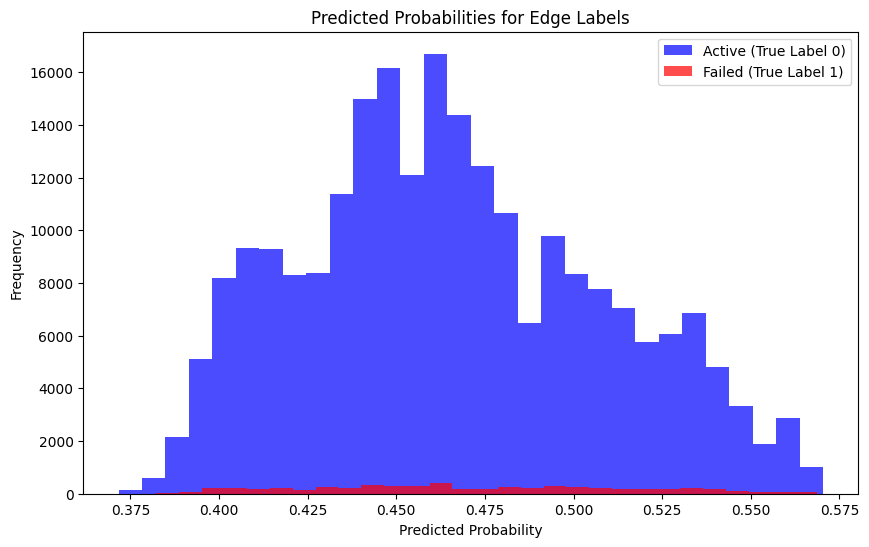

In [12]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Collect true labels and predicted probabilities
true_labels = []
predicted_probs = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        output = model(batch)
        probs = F.softmax(output, dim=1)[:, 1]  # Probability for class '1' (Failed)
        true_labels.extend(batch.y.cpu().numpy())
        predicted_probs.extend(probs.cpu().numpy())

# Plot predictions
plt.figure(figsize=(10, 6))
plt.hist([predicted_probs[i] for i in range(len(true_labels)) if true_labels[i] == 0],
         bins=30, alpha=0.7, label='Active (True Label 0)', color='blue')
plt.hist([predicted_probs[i] for i in range(len(true_labels)) if true_labels[i] == 1],
         bins=30, alpha=0.7, label='Failed (True Label 1)', color='red')
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Predicted Probabilities for Edge Labels")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Threshold predictions to classify
threshold = 0.5
predicted_labels = [1 if p > threshold else 0 for p in predicted_probs]

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Active (0)", "Failed (1)"])
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, inputs):
        # Unpack the tuple and pass as positional arguments
        x, edge_index, edge_attr = inputs
        return self.model(x, edge_index, edge_attr)


In [ ]:
# Wrap the model
wrapped_model = ModelWrapper(model)

# Prepare a batch from the training loader
train_batch = next(iter(train_loader)).to(device)

# Create the SHAP explainer with correctly formatted input
explainer = shap.DeepExplainer(wrapped_model, [(train_batch.x, train_batch.edge_index, train_batch.edge_attr)])

# Use a batch from the test loader for SHAP value calculation
test_batch = next(iter(test_loader)).to(device)

# Generate SHAP values
shap_values = explainer.shap_values((test_batch.x, test_batch.edge_index, test_batch.edge_attr))

# Visualize SHAP values for edge attributes
shap.summary_plot(shap_values[1], test_batch.edge_attr.cpu().numpy(), feature_names=["F1", "F2", "F3", "F4", "F5"])


In [ ]:
import torch
from torch.nn import Module
from torch_geometric.nn import GCNConv
import shap
from torch_geometric.loader import DataLoader

# Example GNN Model
class GNN(Module):
    def __init__(self, in_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index, edge_attr=None):
        # Standard GNN forward method
        return self.conv1(x, edge_index)

# Data Preparation (Example)
from torch_geometric.data import Data

data = Data(
    x=torch.rand((4, 10)),  # 4 nodes with 10 features each
    edge_index=torch.tensor([[0, 1, 2, 3], [1, 2, 3, 0]], dtype=torch.long),  # Edge list
    edge_attr=torch.rand((4, 5))  # 4 edges with 5 features each
)

# Split into train and test loaders
dataset = [data] * 10  # Example dataset of 10 identical graphs
train_loader = DataLoader(dataset[:8], batch_size=1)
test_loader = DataLoader(dataset[8:], batch_size=1)

# Model instantiation
model = GNN(in_channels=10, out_channels=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Wrapper for SHAP compatibility
class ModelWrapper(Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x, edge_index, edge_attr=None):
        # Forward propagation in the GNN
        return self.model(x, edge_index, edge_attr)

# Wrap the model
wrapped_model = ModelWrapper(model)

# Training Batch (SHAP Reference Input)
train_batch = next(iter(train_loader)).to(device)

# Initialize SHAP Explainer
# Pass only `x` and `edge_attr` (exclude `edge_index`)
explainer = shap.DeepExplainer(
    wrapped_model,
    [train_batch.x, train_batch.edge_attr]  # Only floating-point tensors
)

# Test Batch (SHAP Value Calculation)
test_batch = next(iter(test_loader)).to(device)

# Generate SHAP Values
# Again, pass only `x` and `edge_attr`
shap_values = explainer.shap_values([test_batch.x, test_batch.edge_attr])

# Visualize SHAP Values for Node Features (x)
shap.summary_plot(
    shap_values[0],  # SHAP values for `x`
    test_batch.x.cpu().numpy(),  # Convert node features to NumPy
    feature_names=[f"Feature {i}" for i in range(test_batch.x.size(1))]
)

# Visualize SHAP Values for Edge Attributes (if edge_attr is used)
if test_batch.edge_attr is not None:
    shap.summary_plot(
        shap_values[1],  # SHAP values for `edge_attr`
        test_batch.edge_attr.cpu().numpy(),  # Convert edge attributes to NumPy
        feature_names=[f"Edge Feature {i}" for i in range(test_batch.edge_attr.size(1))]
    )
